#### **Установка всех необходимых библиотек**

In [ ]:
from google.colab import files
from IPython.display import clear_output

files.upload()
clear_output()

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
!chmod 600 kaggle.json
!cp kaggle.json ~/.kaggle/

In [ ]:
!pip install -U torchmetrics
clear_output()

#### **Скачивание данных**

In [ ]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

 32% 13.0M/41.0M [00:00<00:00, 136MB/s]
100% 41.0M/41.0M [00:00<00:00, 228MB/s]


In [ ]:
!unzip fake-and-real-news-dataset.zip
!rm -rf fake-and-real-news-dataset.zip True.csv

Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2022-03-18 09:02:53--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.184.253
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.184.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  65.5MB/s    in 33s     

2022-03-18 09:03:26 (47.9 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



#### **Импорт библиотек**

In [ ]:
import random
import re
from collections import Counter
from itertools import chain
from string import punctuation

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from gensim.models import KeyedVectors
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, ParameterGrid
from torch.utils.data import (
    DataLoader,
    Dataset,
    RandomSampler,
    SequentialSampler,
)
from torchmetrics.functional.classification.f_beta import f1_score
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams["figure.figsize"] = (18, 6)

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop = set(stopwords.words("english"))

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#### **Препроцессинг**

In [ ]:
df = pd.read_csv("Fake.csv").drop_duplicates().reset_index(drop=True)

In [ ]:
df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Посмотрим на распределение категорий.

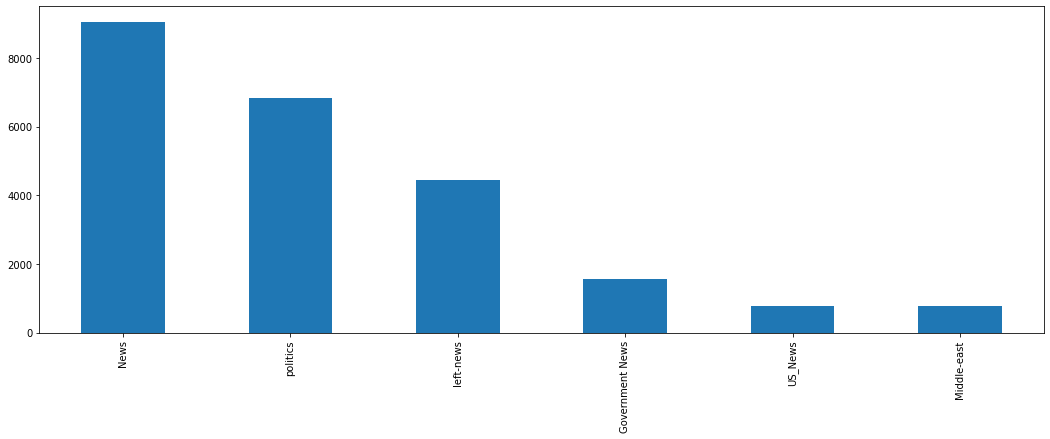

In [ ]:
df["subject"].value_counts().plot.bar()

Несбалансированно, следовательно, когда будем делить датасет на обучающую и тестовую выборку, нужно использовать аргумент stratify.

In [ ]:
def clean_text(text: str) -> str:
    """
    Функция для препроцессинга текстов.
    Приводит текст к нижнему регистру,
    удаляет пунктуацию и стоп-слова,
    проводит токенизацию.

    Parameters:
        text: str

    Returns:
        str
    """
    text = text.lower()
    text = text.translate(str.maketrans("", "", punctuation))
    return [word for word in word_tokenize(text) if word not in stop]

In [ ]:
df["text"] = df["text"].apply(clean_text)

In [ ]:
categories = df["subject"].astype("category")
df["category"] = categories.cat.codes

In [ ]:
target_names = categories.cat.categories
print(dict(enumerate(target_names)))

{0: 'Government News', 1: 'Middle-east', 2: 'News', 3: 'US_News', 4: 'left-news', 5: 'politics'}


In [ ]:
df = df[["text", "category"]]

In [ ]:
df.head()

,text,category
0,"[donald, trump, wish, americans, happy, new, y...",2
1,"[house, intelligence, committee, chairman, dev...",2
2,"[friday, revealed, former, milwaukee, sheriff,...",2
3,"[christmas, day, donald, trump, announced, wou...",2
4,"[pope, francis, used, annual, christmas, day, ...",2


In [ ]:
vocab = Counter(chain(*df["text"]))
print(f"Всего уникальных токенов: {len(vocab)}")

Всего уникальных токенов: 186722


In [ ]:
filtered_vocab = {word for word in vocab if vocab[word] > 2}
print(f"Токенов, встретившихся больше 2 раз: {len(filtered_vocab)}")

Токенов, встретившихся больше 2 раз: 59948


In [ ]:
word2id = {"UNK": 0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [ ]:
print(f"Самое длинное предложение: {max([len(text) for text in df['text']])}")
print(
    f"Средняя длина предложения: {np.mean([len(text) for text in df['text']])}"
    )

Самое длинное предложение: 4920
Средняя длина предложения: 235.27089189879888


Ограничим длину предложения — до чуть больше средней.

In [ ]:
MAX_LEN = 256

In [ ]:
word2vec = KeyedVectors.load_word2vec_format(
    "GoogleNews-vectors-negative300.bin.gz", binary=True
    )

In [ ]:
weights = np.zeros((len(word2id), 300))

unknown_word = 0
for word, i in word2id.items():
    try:
        weights[i] = word2vec[word]
    except KeyError:
        unknown_word += 1
        weights[i] = np.random.uniform(-0.25, 0.25, 300)

weights = torch.FloatTensor(weights)

In [ ]:
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["category"]
    )

In [ ]:
!rm Fake.csv GoogleNews-vectors-negative300.bin.gz

In [ ]:
del word2vec

#### **Dataset & DataLoader**

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset["text"].values
        self.target = dataset["category"].values
        self.length = dataset.shape[0]
        self.word2id = word2id
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index]
        token_ids = []
        ids = torch.LongTensor(
            [self.word2id[token]
             if token in self.word2id else self.word2id["UNK"]
             for token in tokens][:MAX_LEN]
             )
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): 
        ids, y = list(zip(*batch))
        padded_ids = torch.LongTensor(
            torch.stack(
                [F.pad(idx, (1, MAX_LEN - len(idx))) for idx in ids], dim=0
                )
            ).to(self.device)
        y = torch.LongTensor(y).view(len(y)).to(self.device)
        return padded_ids, y

In [ ]:
train_dataset = NewsDataset(train_df, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(
    train_dataset, collate_fn=train_dataset.collate_fn, sampler=train_sampler,
    batch_size=128
    )

val_dataset = NewsDataset(val_df, word2id, DEVICE)
val_sampler = RandomSampler(val_dataset)
val_iterator = DataLoader(
    val_dataset, collate_fn=val_dataset.collate_fn, sampler=val_sampler,
    batch_size=128
    )

#### **Архитектура модели**

In [ ]:
class RNNCell(nn.Module):
    def __init__(self, embedding_size, hidden_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.W_i = torch.randn(self.embedding_size, self.hidden_size)
        self.W_h = torch.randn(self.hidden_size, self.hidden_size)
        self.b = torch.zeros(1, hidden_size)
        self.tanh = nn.Tanh()

    def forward(self, x, h):
        cell_output = self.tanh(x @ self.W_i + self.b + h @ self.W_h + self.b)
        return cell_output

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, embedding_size, hidden_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.W_i = torch.randn(self.embedding_size, self.hidden_size)
        self.W_h = torch.randn(self.hidden_size, self.hidden_size)
        self.b = torch.zeros(1, hidden_size)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, h, cell_state):
        i = self.sigmoid(x @ self.W_i + self.b + h @ self.W_h + self.b)
        f = self.sigmoid(x @ self.W_i + self.b + h @ self.W_h + self.b)
        g = self.tanh(x @ self.W_i + self.b + h @ self.W_h + self.b)
        o = self.sigmoid(x @ self.W_i + self.b + h @ self.W_h + self.b)
        cell_state = cell_state * f + i * g
        cell_output = self.tanh(cell_state) * o
        return cell_output, cell_state

In [ ]:
class GRUCell(nn.Module):
    def __init__(self, embedding_size, hidden_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.W_i = torch.randn(self.embedding_size, self.hidden_size)
        self.W_h = torch.randn(self.hidden_size, self.hidden_size)
        self.b = torch.zeros(1, self.hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, h):
        r = self.sigmoid(x @ self.W_i + self.b + h @ self.W_h + self.b)
        z = self.sigmoid(x @ self.W_i + self.b + h @ self.W_h + self.b) 
        n = self.tanh(x @ self.W_i + self.b + r * (h @ self.W_h + self.b))
        cell_output = (1 - z) * n + z * h
        return cell_output

In [ ]:
class RNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, cell_type="lstm"):
        super().__init__()
        self.hidden_size = out_channels
        self.cell_type = cell_type
        if cell_type == "rnn":
            self.rnn_cell = RNNCell(in_channels, out_channels)
        elif cell_type == "lstm":
            self.rnn_cell = LSTMCell(in_channels, out_channels)
        elif cell_type == "gru":
          self.rnn_cell = GRUCell(in_channels, out_channels)
        else:
            raise ValueError("cell_type must be one of ['rnn', 'lstm', 'gru']")

    def forward(self, x):
        hidden_state = torch.zeros(
            (self.hidden_size), dtype=torch.float32
            ).to(DEVICE)
        cell_state = torch.zeros(
            (self.hidden_size), dtype=torch.float32
            ).to(DEVICE)
        seq_length = x.size()[1]
        for i in range(seq_length):
            input_token = x[:, i, :]
            if self.cell_type == "lstm":
                hidden_state, _ = self.rnn_cell(
                    input_token, hidden_state, cell_state
                    )
            else:
                hidden_state = self.rnn_cell(input_token, hidden_state)
        return hidden_state

In [ ]:
class CLSTM(nn.Module):
    def __init__(
        self, weights, vocab_size, max_len, cell_type="lstm", filter_size=2
        ):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.max_len = max_len
        self.max_filter = self.max_len - filter_size + 1
        self.vocab_size = vocab_size      
        self.conv = nn.Conv1d(
            in_channels=300, out_channels=150, kernel_size=filter_size
            )
        self.rnn = RNNLayer(
            in_channels=150, out_channels=150, cell_type=cell_type
            )
        self.relu = nn.ReLU()
        self.out = nn.Softmax(dim=1)
        self.linear = nn.Linear(150, 6)

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1, 2)
        hidden = self.relu(self.conv(embedded))
        hidden = hidden[:, :, :self.max_filter]
        hidden_state = self.rnn(hidden.transpose(1, 2))
        logits = self.out(self.linear(torch.squeeze(hidden_state, 0)))
        return logits

#### **Функции для обучения и валидации**

In [ ]:
def train_epoch(model, iterator, optimizer, criterion, metric, n_epoch):
    progress_bar = tqdm(
        total=len(iterator.dataset), desc=f"Epoch {n_epoch + 1}"
        )
    epoch_loss = 0.0
    epoch_metric = 0.0
    model.train()

    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, ys)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        batch_metric = metric(
            preds.argmax(1).long(), ys.long(), average="weighted",
            num_classes=6, ignore_index=False
            )
        epoch_metric += batch_metric.cpu().numpy()
        progress_bar.update(texts.shape[0])

    progress_bar.close()
    return epoch_loss / len(iterator), epoch_metric / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, metric):
    epoch_loss = 0.0
    epoch_metric = 0.0
    model.eval()

    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = metric(
                preds.argmax(1).long(), ys.long(), average="weighted",
                num_classes=6, ignore_index=False
                )
            epoch_metric += batch_metric.cpu().numpy()

    return  epoch_loss / len(iterator), epoch_metric / len(iterator)

In [ ]:
def train(
    model, train_iterator, val_iterator, optimizer, criterion, metric, epochs
    ):
    train_losses = []
    train_scores = []
    val_losses = []
    val_scores = []

    for n in range(epochs):
        print("Training")
        train_loss, train_score = train_epoch(
            model, train_iterator, optimizer, criterion, metric, n
            )
        train_losses.append(train_loss)
        train_scores.append(train_score)
        print(f"train loss: {train_loss} train score: {train_score}")
        print("Validation")
        val_loss, val_score = evaluate(model, val_iterator, criterion, metric)
        val_losses.append(val_loss)
        val_scores.append(val_score)
        print(f"val loss: {val_loss} val score: {val_score}")

    return train_losses, train_scores, val_losses, val_scores

In [ ]:
def predict(model, iterator):
    true = []
    preds = []
    model.eval()

    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds.extend(
                torch.argmax(model(texts), dim=1).cpu().detach().numpy()
                )
            true.extend(ys.cpu().detach().numpy())
    return true, preds

In [ ]:
def grid_search(
    train_iterator, val_iterator, param_grid, weights, vocab_size, max_len,
    lr=0.001, weight_decay=0.0001, metric=f1_score, epochs=5
    ):
    results = []
    best_metric = 0.0
    best_model = None
    best_params = None

    for params in tqdm(ParameterGrid(param_grid)):
        print(f"Params: {params}")
        curr_params = {
            "weights": weights,
            "vocab_size": vocab_size,
            "max_len": max_len
        }
        curr_params.update(params)
        model = CLSTM(**curr_params)
        optimizer = torch.optim.RMSprop(
            model.parameters(), lr=lr, weight_decay=weight_decay
            )
        criterion = nn.CrossEntropyLoss()
        model = model.to(DEVICE)
        criterion = criterion.to(DEVICE)
        train_losses, train_scores, val_losses, val_scores = train(
            model, train_iterator, val_iterator, optimizer, criterion, metric,
            epochs
            )

        if val_scores[-1] > best_metric:
            best_metric = val_scores[-1]
            best_model = model
            best_params = params

        results.append({
            "params": params,
            "train losses": train_losses,
            "train scores": train_scores,
            "val losses": val_losses,
            "val scores": val_scores,
        })
    print("\n")

    return results, best_metric, best_model, best_params

#### **Эксперименты**

In [ ]:
param_grid = {
    "cell_type": ["rnn", "lstm", "gru"],
    "filter_size": [2, 3],
}

In [ ]:
results, best_f1, best_model, best_params = grid_search(
    train_iterator, val_iterator, param_grid, weights, len(word2id), MAX_LEN
    )

  0%|          | 0/6 [00:00<?, ?it/s]

Params: {'cell_type': 'rnn', 'filter_size': 2}
Training


Epoch 1:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009765938973112894
Validation
val loss: nan val score: 0.009109754813835025
Training


Epoch 2:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009120718419209731
Validation
val loss: nan val score: 0.00904781066787404
Training


Epoch 3:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009317084841016794
Validation
val loss: nan val score: 0.009044014949452233
Training


Epoch 4:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009132000549378025
Validation
val loss: nan val score: 0.008928495522972348
Training


Epoch 5:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009164648578378695
Validation
val loss: nan val score: 0.009357055593313448
Params: {'cell_type': 'rnn', 'filter_size': 3}
Training


Epoch 1:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.010392803006621749
Validation
val loss: nan val score: 0.009109636730942372
Training


Epoch 2:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009070763171398632
Validation
val loss: nan val score: 0.00920230508986483
Training


Epoch 3:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009162865324123274
Validation
val loss: nan val score: 0.009189093963721313
Training


Epoch 4:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009231158321743932
Validation
val loss: nan val score: 0.009284462314885663
Training


Epoch 5:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009226100469407226
Validation
val loss: nan val score: 0.00936997340790726
Params: {'cell_type': 'lstm', 'filter_size': 2}
Training


Epoch 1:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.02460334633142833
Validation
val loss: nan val score: 0.009143825639290986
Training


Epoch 2:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009164733540181222
Validation
val loss: nan val score: 0.008875854075036792
Training


Epoch 3:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.00917847946857983
Validation
val loss: nan val score: 0.009292090166913899
Training


Epoch 4:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.00924270931586978
Validation
val loss: nan val score: 0.009453103891762628
Training


Epoch 5:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009215102794138258
Validation
val loss: nan val score: 0.009377274712598001
Params: {'cell_type': 'lstm', 'filter_size': 3}
Training


Epoch 1:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.01037230858338528
Validation
val loss: nan val score: 0.009215429727290128
Training


Epoch 2:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009046942033831879
Validation
val loss: nan val score: 0.008992557508266857
Training


Epoch 3:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.00908928529189529
Validation
val loss: nan val score: 0.009238228327720551
Training


Epoch 4:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009304552340601274
Validation
val loss: nan val score: 0.00934084111547752
Training


Epoch 5:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009332895345453705
Validation
val loss: nan val score: 0.008871610427426325
Params: {'cell_type': 'gru', 'filter_size': 2}
Training


Epoch 1:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: 1.6045713603091079 train score: 0.3573508305209024
Validation
val loss: 1.5815606922716707 val score: 0.3673053367717846
Training


Epoch 2:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: 1.5802325204927095 train score: 0.37039663738944906
Validation
val loss: 1.5736654642465953 val score: 0.37411182716086105
Training


Epoch 3:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: 1.5749084065560581 train score: 0.3723829293332132
Validation
val loss: 1.5695203220522083 val score: 0.3758392019851788
Training


Epoch 4:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: 1.571463644910021 train score: 0.3746401625020163
Validation
val loss: 1.566762695441375 val score: 0.3737192371407071
Training


Epoch 5:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: 1.5693222349192821 train score: 0.37496985292353596
Validation
val loss: 1.5654437058680766 val score: 0.37678988479279185
Params: {'cell_type': 'gru', 'filter_size': 3}
Training


Epoch 1:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: 1.5980120735103582 train score: 0.36597332500276114
Validation
val loss: 1.5770378112792969 val score: 0.3772152807261493
Training


Epoch 2:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: 1.5740567745805598 train score: 0.37446298972279035
Validation
val loss: 1.569912823470863 val score: 0.38049259137462926
Training


Epoch 3:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: 1.5687332972377337 train score: 0.37609099267291374
Validation
val loss: 1.5664343543954797 val score: 0.38474682617831873
Training


Epoch 4:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: 1.5649364635246952 train score: 0.379825051341738
Validation
val loss: 1.5635187690322463 val score: 0.3820235479522396
Training


Epoch 5:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: 1.5621854010082425 train score: 0.38196536412044446
Validation
val loss: 1.5627070439828408 val score: 0.38423080540992116




#### **Оценка результатов**
Выведем наилучшие параметры модели.

In [ ]:
print(best_params)

In [ ]:
print(best_f1)

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
results_df.insert(
    0, "cell_type", results_df["params"].apply(lambda x: x["cell_type"])
    )
results_df.insert(
    1, "filter_size", results_df["params"].apply(lambda x: x["filter_size"])
    )
results_df.insert(
    2, "drop_start", results_df["params"].apply(lambda x: x["drop_start"])
    )
results_df.insert(
    3, "loss", results_df["val losses"].apply(lambda x: x[-1])
    )
results_df.insert(
    4, "f1-score", results_df["val scores"].apply(lambda x: x[-1])
    )
results_df = results_df.drop("params", axis=1)

Посмотрим на loss и f1-score при разных параметрах (отсортируем параметры от самых лучших к самым худшим):

In [ ]:
results_df = results_df.sort(["f1-score", "loss"], ascending=[False, True])

In [ ]:
results_df.head()

Посмотрим на то, как менялись loss и f1-score в процессе обучения модели с наилучшими параметрами.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(results_df["train losses"][0], label="train")
ax1.plot(results_df["val losses"][0], label="val")
ax1.set_title("BCE loss value")
ax1.set(xlabel="epoch", ylabel="BCE loss")
ax1.legend(loc="upper right")

ax2.plot(results_df["train scores"][0], label="train")
ax2.plot(results_df["val scores"][0], label="val")
ax2.set_title("F1 score")
ax2.set(xlabel="epoch", ylabel="F1 score")
ax2.legend(loc="upper right")

fig.suptitle("Training (filter_sizes=, drop_start=)")

Посмотрим на предсказания наилучшей модели.

In [ ]:
y_true, y_pred = predict(best_model, val_iterator)

Построим матрицу ошибок.

In [ ]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=target_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")

Посмотрим на метрики оценки качества классификации для разных классов.

In [ ]:
print(classification_report(y_true, y_pred, target_names=target_names))

#### **Выводы**